<a href="https://colab.research.google.com/github/n1az/Bayes-IDA/blob/main/exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code implements the Lorenz-63 model using Euler's method and stores the resulting reference trajectory in time intervals of Δt_out = 0.05 in a file named 'lorenz_63_data.txt' for later use. The system state is not stored at every single timestep but is overwritten on each timestep and a copy of the vector is taken when it needs to be stored. The resulting data set is stored in a matrix of size 3 × 4001.



This code loads the data from the file 'lorenz_63_data.txt', extracts the x-solution component, creates a time array and plots the x-solution component against time using `matplotlib`. You can customize the plot by changing the labels, title and other properties.



In [16]:
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Set the initial conditions and time step
x0, y0, z0 = -0.587, -0.563, 16.870
dt = 0.001
num_steps = int(50/dt)
a = 1/np.sqrt(dt)
t_out = 0.05

# Initialize the forcing term
gn = np.array([a * (1/np.sqrt(2) - 0.5), 
                a * (1/np.sqrt(3) - 0.5), 
                a * (1/np.sqrt(5) - 0.5)])


In [17]:
# Initialize the state vector and counter for output time intervals
state = np.empty((num_steps+1, 3))
state[0] = (x0, y0, z0)
out_count = 0

# create an array to store the data
datax = np.zeros((3, 4001))
datax[:, out_count] = state[0]


In [18]:
def lorenz(xyz, *, s=10, r=28, b=8/3):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz 
    x_dot = s*(y - x) 
    y_dot = r*x - y - x*z 
    z_dot = x*y - b*z 
    return np.array([x_dot, y_dot, z_dot])




In [19]:
# Define the non-autonomous forcing term g
def g(gn):
    # Define the forcing term as a recursive function of gn
    for i in range(3):
        if gn[i] >= -a/2 and gn[i] < 0:
            gn[i] = 1.99999 * gn[i] + a/2
        else:
            gn[i] = -1.99999 * gn[i] + a/2
    return gn



In [20]:
# and using them to estimate the next point
for i in range(num_steps):
    state[i+1] = state[i] + dt * (lorenz(state[i]) + gn)
    #update forcing term
    gn = g(gn)
    # Store the data at output time intervals
    if i * dt % t_out == 0:
        datax[:, out_count] = state[i]
        out_count += 1

# Save the data to a file
np.savetxt('lorenz_63_data.txt', datax)


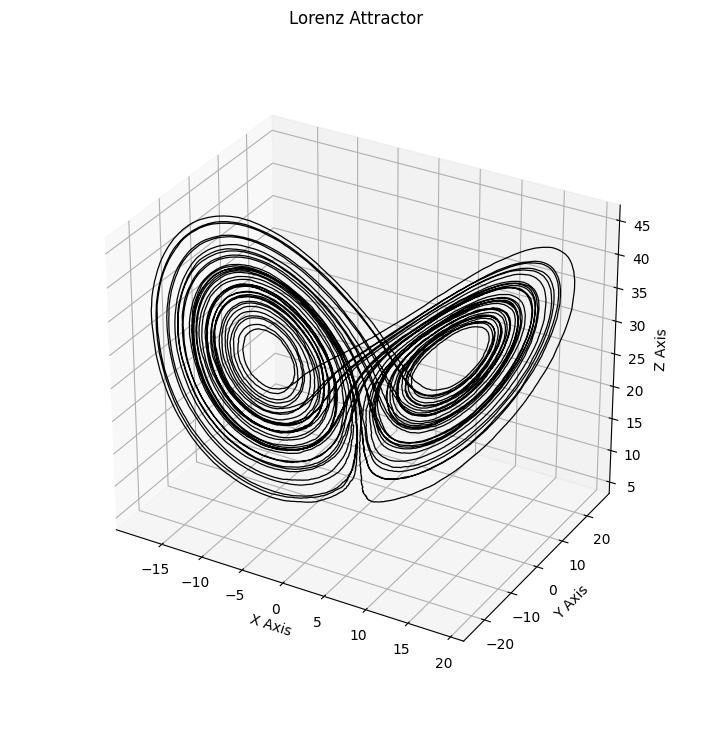

In [21]:
# Plot
ax = plt.figure(figsize=(9,9)).add_subplot(projection='3d')
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.9, 0.7, 1, 1]))
ax.plot(*state.T, lw=0.9, c='k')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.show()

In [22]:
datax.shape

(3, 4001)

In [ ]:
# initializing starting values
a = 4
xi = a*(1/np.sqrt(2)-0.5)
